# Ejercicio: clasificando dígitos con redes densas

<img src="https://albarji-labs-materials.s3-eu-west-1.amazonaws.com/mnist.jpeg" style="width:480px;">

En este ejercicio vamos a tratar de identificar imágenes de dígitos escritos a mano. Usaremos este problema como un campo de pruebas para utilizar diferentes arquitecturas de red neuronal.

## Guía general

A lo largo del notebook encontrarás celdas que debes rellenar con tu propio código. Sigue las instrucciones del notebook y presta atención a los siguientes iconos:

<img src="https://albarji-labs-materials.s3-eu-west-1.amazonaws.com/question.png" height="80" width="80" style="float: right;"/>

***

<font color=#ad3e26>
Deberás resolver el ejercicio escribiendo tu propio código o respuesta en la celda inmediatamente inferior.</font>

***

<img src="https://albarji-labs-materials.s3-eu-west-1.amazonaws.com/exclamation.png" height="80" width="80" style="float: right;"/>

***
<font color=#2655ad>
Esto es una pista u observación de utilidad que puede ayudarte a resolver el ejercicio. Presta atención a estas pistas para comprender el ejercicio en mayor profundidad.
</font>

***

<img src="https://albarji-labs-materials.s3-eu-west-1.amazonaws.com/pro.png" height="80" width="80" style="float: right;"/>

***
<font color=#259b4c>
Este es un ejercicio avanzado que te puede ayudar a profundizar en el tema. ¡Buena suerte!</font>

***

Para evitar problemas con imports o incompatibilidades se recomienda ejecutar este notebook en uno de los [entornos de Deep Learning recomendados](https://github.com/albarji/teaching-environments-deeplearning), o hacer uso [Google Colaboratory](https://colab.research.google.com/). Si usas Colaboratory, asegúrate de [conectar una GPU](https://colab.research.google.com/notebooks/gpu.ipynb).

El siguiente código mostrará todas las gráficas en el propio notebook en lugar de generar una nueva ventana.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

También vamos a fijar las semillas aleatorias de numpy y tensorflow para obtener resultados reproducibles entre varias ejecuciones del notebook

In [2]:
import numpy as np
import tensorflow as tf
np.random.seed(1)
tf.random.set_seed(2)

Finalmente, si necesitas ayuda en el uso de cualquier función Python, coloca el cursor sobre su nombre y presiona Shift+Tab. Aparecerá una ventana con su documentación. Esto solo funciona dentro de celdas de código.

¡Vamos alla!

## Carga de datos

El dataset de reconocimiento de dígitos que vamos a trabajar ya está incluído en la librería Keras. Para cargalo solo necesitamos ejecutar lo siguiente

In [3]:
from tensorflow.keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


Las variables **X** que se han cargado están formadas por los dígitos manuscritos a clasificar, mientras que las variables **y** nos indican las etiquetas de las imágenes correspondientes en X. Usaremos los datos de **train** para entrenar nuestra red neuronal, y los datos de **test** para medir el rendimiento de la red.

Podemos comprobar cuántas imágenes tenemos para entrenar y testear de la siguiente manera:

In [4]:
len(X_train)

60000

In [5]:
len(X_test)

10000

También podemos comprobar la forma (ancho y alto en píxeles) de una imagen:

In [6]:
X_test[0].shape

(28, 28)

Podemos visualizar las imágenes del dataset a través de la librería **matplotlib**. En la siguiente celda tomamos la primera imagen de entrenamiento y la visualicemos en una escala de grises. También estamos imprimiendo la clase correspondiente a esa imagen, para comprobar que el etiquetado de la imagen es correcto.

Digit class: 5


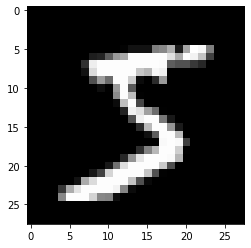

In [7]:
plt.imshow(X_train[0], 'gray')
print("Digit class:", y_train[0])

## Preparación de datos

### Normalización de las entradas

Ante de construir una red neuronal, primero debemos siempre normalizar los datos. Generalmente la normalización implica restar la media y dividir la desviación estándar de los datos. No obstante, para el caso de imágenes en escala de gris como estas, cada valor de los datos representa la intensidad de un pixel, un valor que está acotado en el rango [0, 255]. Podemos por tanto realizar una normalización sencilla consistente en dividir los datos por 255 para que se queden ajustados al rango [0, 1]. También necesitaremos tranformar el tipo de datos a `float`, o de otro modo no podremos representar valores decimales.

In [8]:
X_train_norm = X_train.astype('float32') / 255

<img src="https://albarji-labs-materials.s3-eu-west-1.amazonaws.com/question.png" height="80" width="80" style="float: right;"/>

***

<font color=#ad3e26>
Realiza la misma normalización para los datos de entrada de test.
</font>

***

In [10]:
####### INSERT YOUR CODE HERE
X_test_norm = X_test.astype('float32') / 255

### Codificación de las salidas

Los datos de salida para una red neuronal no requieren normalización, pero sí deben ser codificados siguiendo un formato en particular. En lugar de tener un valor entero en el rango [0, 9] que indique la clase de la imagen, utilizaremos una codificación de tipo <a href="https://en.wikipedia.org/wiki/One-hot">one-hot</a>.

In [11]:
from tensorflow.keras.utils import to_categorical
y_train_encoded = to_categorical(y_train, 10) # We have 10 classes to codify

Podemos comprobar que la transformación ha generado una codificación one-hot correcta

In [12]:
y_train_encoded

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

<img src="https://albarji-labs-materials.s3-eu-west-1.amazonaws.com/question.png" height="80" width="80" style="float: right;"/>

***

<font color=#ad3e26>
Realiza la misma codificación para los datos de salida de test.
</font>

***

In [13]:
y_test_encoded = to_categorical(y_test, 10) # We have 10 classes to codify

### Aplanado (flattening) de las entradas

Nuestra preparación de datos está casi terminada, pero falta un pequeño detalle: nuestros datos son imágenes bidimensionales, pero una red neuronal estándar solo es capaz de trabajar con datos en la forma de vectores unidimensionales de variables. Debemos transformar los datos a vectores antes de introducirlos en la red neuronal, algo que podemos hacer con el método `reshape`. Dado que tenemos 60000 imágenes de entrenamiento de 28x28 (784 en total) píxeles, el `reshape` a realizar es:

In [14]:
trainvectors = X_train_norm.reshape(60000, 784)

Podemos comprobar ahora que nuestros datos de entrenamiento se han convertido en una matriz de 60000 datos (filas) y 784 variables (columnas).

In [15]:
trainvectors.shape

(60000, 784)

<img src="https://albarji-labs-materials.s3-eu-west-1.amazonaws.com/question.png" height="80" width="80" style="float: right;"/>

***

<font color=#ad3e26>
Realiza una transformación similar para los datos de entrada de test (X_test), guardando los datos tras el reshape en una nueva varible llamada <b>testvectors</b>. Ten en cuenta que en test contamos con 10000 imágenes, en lugar de las 60000 de entrenamiento.
</font>

***

In [16]:
####### INSERT YOUR CODE HERE
testvectors = X_test_norm.reshape(10000, 784)

Ten en mente que este aplanado en vectores unidimensionales es algo que solo necesitamos hacer para el tipo de redes que trabajaremos en este notebook. Cuando en otros notebooks avancemos a redes especializadas en imágenes, podremos hacer que la red utilice directamente las imágenes como entradas.

## Perceptrón

Empezaremos tratando el problema con la red neuronal más sencilla: un perceptrón. Esto quiere decir que tendremos una red neuronal sin capas ocultas, únicamente conexiones desde las entradas a las salidas.

### Definiendo la red

Para construir una red en Keras primero debemos definir el tipo de arquitectura:

* **Sequential**: cada nueva capa se conecta a la capa declarada inmediatamente antes en la red, siguiendo una cadena.
* **Functional**: cada capa puede conectarse a la salida de cualquier otra capa declarada antes en la red, siempre y cuando no se formen ciclos.

Para este ejercicio será suficiente con una arquitectura de tipo Sequential.

In [17]:
from tensorflow.keras.models import Sequential
perceptron = Sequential()

Una vez la red ha sido inicializada, podemos ir añadiendo las capas deseadas de manera iterativa. Para construir un perceptrón solo nos hará falta una capa "clásica" de pesos desde las entradas a la salida. En Deep Learning moderno este tipo de capas se llaman **Dense**, porque conectan todas las variables de entrada con todas las salidas de la capa.

In [18]:
from tensorflow.keras.layers import Dense

Para crear una capa densa suele bastar con declarar el número de unidades de salida (o desde un punto de vista clásico, el número de neuronas). No obstante, en un modelo de tipo Sequential estamos obligados a declarar el número de variables de entrada a la red neuronal cuando creamos nuestra primera capa. En este problema tenemos 784 variables explicativas (28x28 píxeles). En cuanto a las salidas, en este problema tenemos 10 clases, por lo que deberemos crear 10 unidades de salida. También debemos tener en consideración que estamos trabajando un problema multiclase, y por tanto debemos escoger una función de activación que delimite los valores de salida de la red al rango [0, 1], asegurando que la suma de todos estos valores es `1`. La activación `softmax` es la adecuada en estos casos.

In [19]:
perceptron.add(Dense(10, input_dim=784, activation="softmax"))

Con esto, la definición de la red está completa. Podemos confirmar que la hemos construído correctamente pidiendo a Keras un resumen del modelo.

In [20]:
perceptron.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                7850      
                                                                 
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


### Compilando la red

Tras definir la red, debemos realizar la compilación de la misma. La compilación es un proceso automático que transforma la definición de la red en una formulación simbólica equivalente para la que pueden calcularse las derivadas, permitiendo así ejecutar el algoritmo de retropropagación (backpropagation). Los únicos parámetros que debemos especificar son la función de pérdida o error que la red debe minimizar, y el optimizador a usar durante el aprendizaje.

Dado que estamos tratando con un problema de clasificación multiclase, la función de pérdida más adecuada es la **categorical crossentropy**. En cuanto al optimizador, de momento utilizaremos el **Stochastic Gradient Descent**. Como parámetro opcional, solicitaremos que como métrica se nos informe de la **accuracy** durante el entrenamiento de la red.

In [21]:
perceptron.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

### Entrenando la red

Ahora podemos invocar al método `fit` de la red, el encargado de ejecutar el proceso de entrenamiento. Para este problema utilizaremos un tamaño de batch de 128, y 20 épocas de entrenamiento.

In [22]:
perceptron.fit(
    trainvectors, # Training data
    y_train_encoded, # Labels of training data
    batch_size=128, # Batch size for the optimizer algorithm
    epochs=20, # Number of epochs to run the optimizer algorithm
    verbose=2 # Level of verbosity of the log messages
)

Epoch 1/20
469/469 - 3s - loss: 1.2887 - accuracy: 0.7005 - 3s/epoch - 7ms/step
Epoch 2/20
469/469 - 1s - loss: 0.7146 - accuracy: 0.8439 - 1s/epoch - 3ms/step
Epoch 3/20
469/469 - 1s - loss: 0.5860 - accuracy: 0.8604 - 1s/epoch - 2ms/step
Epoch 4/20
469/469 - 1s - loss: 0.5245 - accuracy: 0.8697 - 1s/epoch - 3ms/step
Epoch 5/20
469/469 - 1s - loss: 0.4872 - accuracy: 0.8759 - 1s/epoch - 2ms/step
Epoch 6/20
469/469 - 1s - loss: 0.4615 - accuracy: 0.8801 - 1s/epoch - 3ms/step
Epoch 7/20
469/469 - 1s - loss: 0.4425 - accuracy: 0.8840 - 1s/epoch - 3ms/step
Epoch 8/20
469/469 - 1s - loss: 0.4276 - accuracy: 0.8865 - 1s/epoch - 2ms/step
Epoch 9/20
469/469 - 1s - loss: 0.4156 - accuracy: 0.8891 - 1s/epoch - 2ms/step
Epoch 10/20
469/469 - 1s - loss: 0.4058 - accuracy: 0.8903 - 1s/epoch - 3ms/step
Epoch 11/20
469/469 - 1s - loss: 0.3973 - accuracy: 0.8920 - 1s/epoch - 3ms/step
Epoch 12/20
469/469 - 1s - loss: 0.3900 - accuracy: 0.8941 - 1s/epoch - 3ms/step
Epoch 13/20
469/469 - 1s - loss: 0.38

Ahora que nuestra red está entrenada, podemos obtener predicciones para el conjunto de test como

In [23]:
probs = perceptron.predict(testvectors)

Las predicciones se obtienen como una matriz con forma `(n_datos, clases)`, que pueden interpretarse como las probabilidades de que la imagen pertenezca a cada una de las clases posibles.

In [24]:
probs

array([[2.58102722e-04, 8.01071394e-07, 1.99522023e-04, ...,
        9.94534850e-01, 1.76103087e-04, 2.72493181e-03],
       [1.26140425e-02, 1.63576915e-04, 8.68396878e-01, ...,
        3.76514350e-07, 7.84975663e-03, 4.99391444e-06],
       [1.99456161e-04, 9.50817883e-01, 1.63212810e-02, ...,
        4.42804350e-03, 9.89920553e-03, 1.84979360e-03],
       ...,
       [7.10017912e-06, 2.92644909e-05, 1.47686122e-04, ...,
        6.66955533e-03, 2.16466989e-02, 5.35607561e-02],
       [6.61989488e-03, 8.03831033e-03, 2.10193591e-03, ...,
        1.33099617e-03, 4.83725011e-01, 2.25255056e-03],
       [3.76263139e-04, 2.18210729e-08, 1.20737671e-03, ...,
        7.74323894e-08, 8.18955778e-06, 1.93739811e-06]], dtype=float32)

Si usando estas probabilidades tuviéramos que apostar por qué digito es el que se representa en la imagen, lo más sensato sería decantarnos por el que tiene mayor probabilidad. Podemos hacer esto fácilmente empleando la función [argmax de numpy](https://numpy.org/doc/stable/reference/generated/numpy.argmax.html):

In [25]:
import numpy as np

preds = np.argmax(probs, axis=-1)
preds

array([7, 2, 1, ..., 4, 8, 6])

Ahora que tenemos predicciones, si por ejemplo tomamos el primer ejemplo de test, podemos ver su imagen y la correspondiente clase predicha por la red

Real class 7 predicted class 7


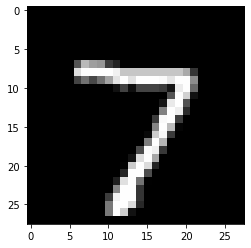

In [26]:
plt.imshow(X_test[0], 'gray')
print("Real class", y_test[0], "predicted class", preds[0])

Puede que para este caso particular hayamos acertado pero, ¿qué ocurre con el resto del dataset de test? Una forma rápida de encontrar todas las imágenes de test en las que hemos fallado es usando la función [where](http://docs.scipy.org/doc/numpy-1.10.1/reference/generated/numpy.where.html) de numpy, que nos devuelve las posiciones en las que una cierta lista contiene el valor `True`. Para este caso, construimos una lista de los índices de las imágenes en las que las predicciones no son correctas, comparando la lista de predicciones con la lista de clases reales de los dígitos de test:

In [27]:
(fails,) = np.where(y_test != preds)
fails

array([   8,   33,   46,   63,   77,   92,  111,  124,  149,  193,  195,
        217,  233,  241,  245,  247,  259,  290,  300,  307,  313,  318,
        320,  321,  340,  341,  352,  358,  362,  389,  403,  435,  444,
        445,  448,  449,  457,  464,  468,  478,  479,  483,  495,  502,
        507,  511,  515,  524,  530,  531,  536,  543,  550,  551,  553,
        565,  569,  578,  582,  591,  605,  610,  613,  619,  624,  627,
        628,  629,  638,  658,  659,  667,  684,  691,  707,  717,  720,
        728,  738,  740,  741,  760,  791,  800,  839,  844,  846,  857,
        877,  881,  898,  900,  924,  930,  938,  939,  944,  947,  950,
        956,  959,  965,  975,  982,  992,  999, 1012, 1014, 1028, 1032,
       1033, 1039, 1044, 1050, 1062, 1068, 1073, 1082, 1096, 1101, 1107,
       1112, 1114, 1119, 1128, 1147, 1153, 1173, 1181, 1191, 1192, 1194,
       1198, 1200, 1202, 1204, 1206, 1208, 1217, 1224, 1226, 1228, 1232,
       1233, 1234, 1242, 1247, 1248, 1251, 1256, 12

Vamos a visualizar alguna de las imágenes en las que la red se ha equivocado:

Real class 5 predicted class 6


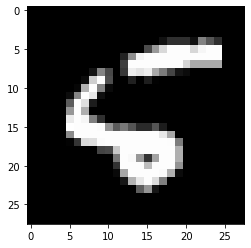

In [28]:
plt.imshow(X_test[fails[0]], 'gray')
print("Real class", y_test[fails[0]], "predicted class", preds[fails[0]])

Podríamos probar cualquier otra imagen fallida del conjunto de test para analizar en qué tipo de imágenes nuestra red está cometiendo errores. Pero si queremos tener una idea más general de cómo de bien está funcionando la red, podemos calcular su acierto (accuracy). Esto se hace con el método `evaluate` de la red neuronal.

In [29]:
score = perceptron.evaluate(testvectors, y_test_encoded)
print("Test loss", score[0])
print("Test accuracy", score[1])

313/313 [==============================] - 1s 3ms/step - loss: 0.3356 - accuracy: 0.9085
Test loss 0.33563685417175293
Test accuracy 0.9085000157356262


Ahora podríamos plantearnos, ¿es este nivel de acierto suficientemente bueno? Imaginemos que nuestro detector de dígitos se usa para escanear los códigos postales de envío de un paquete. Si consideramos que los [códigos postales extendidos de los Estados Unidos](https://en.wikipedia.org/wiki/ZIP_Code) están conformados por 9 dígitos, y que con fallar uno de los dígitos estaríamos enviando un paquete al lugar equivocado... ¿cuál es la probabilidad de mandar el paquete correctamente?

Calcular esta probabilidad es sencillo. Sabemos la probabilidad de que nuestro modelo haga una buena predicción para un solo dígito (la accuracy), así que solo debemos calcular la probabilidad de que el modelo acierte a la vez para los 9 dígitos del código postal. Esta probabilidad conjunta se calcularía como $P(acierto) * P(acierto) * P(acierto) ... = P(acierto)^9$.

In [30]:
score[1]**9

0.42162315378032617

Podemos concluir que usar un perceptrón en este problema tendría resultados catastróficos: solo un 41% de paquetes enviados a la dirección correcta. ¡Necesitamos hacerlo mejor!

## Perceptrón multicapa

Pasando a los años 80, podemos mejorar nuestra red introduciendo **capas ocultas**. En Keras esto se implementa de forma sencilla introduciendo capas Dense adicionales. Por ejemplo, podemos crear una red con una capa oculta de 32 neuronas de la siguiente manera.

In [31]:
mlp = Sequential()
mlp.add(Dense(32, input_dim=784, activation="sigmoid"))
mlp.add(Dense(10, activation="softmax"))

La red quedaría, por tanto, configurada así

In [32]:
mlp.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 32)                25120     
                                                                 
 dense_2 (Dense)             (None, 10)                330       
                                                                 
Total params: 25,450
Trainable params: 25,450
Non-trainable params: 0
_________________________________________________________________


<img src="https://albarji-labs-materials.s3-eu-west-1.amazonaws.com/question.png" height="80" width="80" style="float: right;"/>

***

<font color=#ad3e26>
Compila el perceptrón multicapa y entrénalo con los datos de train. ¿Qué nivel de acierto se obtiene al evaluarlo en test? ¿Has mejorado respecto del perceptrón anterior?
</font>

***


In [33]:
####### INSERT YOUR CODE HERE
mlp.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
mlp.fit(
    trainvectors, # Training data
    y_train_encoded, # Labels of training data
    batch_size=128, # Batch size for the optimizer algorithm
    epochs=20, # Number of epochs to run the optimizer algorithm
    verbose=1 # Level of verbosity of the log messages
)

Epoch 1/20
469/469 [==============================] - 2s 4ms/step - loss: 2.1455 - accuracy: 0.4245
Epoch 2/20
469/469 [==============================] - 2s 3ms/step - loss: 1.7803 - accuracy: 0.6281
Epoch 3/20
469/469 [==============================] - 2s 3ms/step - loss: 1.4917 - accuracy: 0.7042
Epoch 4/20
469/469 [==============================] - 2s 4ms/step - loss: 1.2580 - accuracy: 0.7529
Epoch 5/20
469/469 [==============================] - 2s 3ms/step - loss: 1.0812 - accuracy: 0.7856
Epoch 6/20
469/469 [==============================] - 2s 3ms/step - loss: 0.9503 - accuracy: 0.8050
Epoch 7/20
469/469 [==============================] - 2s 3ms/step - loss: 0.8525 - accuracy: 0.8200
Epoch 8/20
469/469 [==============================] - 2s 3ms/step - loss: 0.7776 - accuracy: 0.8299
Epoch 9/20
469/469 [==============================] - 2s 3ms/step - loss: 0.7186 - accuracy: 0.8397
Epoch 10/20
469/469 [==============================] - 2s 3ms/step - loss: 0.6710 - accuracy: 0.8479

In [37]:
score = mlp.evaluate(testvectors, y_test_encoded)
print("Test loss", score[0])
print("Test accuracy", score[1])

313/313 [==============================] - 1s 3ms/step - loss: 0.4293 - accuracy: 0.8931
Test loss 0.429255872964859
Test accuracy 0.8931000232696533


### Mejorando el diseño de la red

Para mejorar el rendimiento del perceptrón multicapa utilizaremos las siguientes técnicas:
* Mayor número de unidades ocultas
* Mejor función de activación: ReLU
* Mejor optimizador: adam

Definiremos por tanto la red de la seguiente manera:

In [34]:
mlp_fine = Sequential()
mlp_fine.add(Dense(100, input_dim=784, activation="relu"))
mlp_fine.add(Dense(10, activation="softmax"))

<img src="https://albarji-labs-materials.s3-eu-west-1.amazonaws.com/question.png" height="80" width="80" style="float: right;"/>

***

<font color=#ad3e26>
    Compila la red definida arriba, escogiendo "adam" como algoritmo de optimización, y entrénala con los datos de train. Mide el rendimiento sobre los datos de test. ¿Han ayudado estos cambios a mejorar el acierto?
</font>

***

In [35]:
####### INSERT YOUR CODE HERE
####### INSERT YOUR CODE HERE
mlp_fine.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
mlp_fine.fit(
    trainvectors, # Training data
    y_train_encoded, # Labels of training data
    batch_size=128, # Batch size for the optimizer algorithm
    epochs=20, # Number of epochs to run the optimizer algorithm
    verbose=1 # Level of verbosity of the log messages
)

Epoch 1/20
469/469 [==============================] - 2s 4ms/step - loss: 0.3722 - accuracy: 0.8986
Epoch 2/20
469/469 [==============================] - 2s 4ms/step - loss: 0.1705 - accuracy: 0.9523
Epoch 3/20
469/469 [==============================] - 2s 5ms/step - loss: 0.1260 - accuracy: 0.9639
Epoch 4/20
469/469 [==============================] - 2s 4ms/step - loss: 0.0996 - accuracy: 0.9711
Epoch 5/20
469/469 [==============================] - 2s 4ms/step - loss: 0.0822 - accuracy: 0.9761
Epoch 6/20
469/469 [==============================] - 2s 4ms/step - loss: 0.0691 - accuracy: 0.9800
Epoch 7/20
469/469 [==============================] - 2s 4ms/step - loss: 0.0591 - accuracy: 0.9833
Epoch 8/20
469/469 [==============================] - 2s 4ms/step - loss: 0.0503 - accuracy: 0.9855
Epoch 9/20
469/469 [==============================] - 2s 4ms/step - loss: 0.0430 - accuracy: 0.9882
Epoch 10/20
469/469 [==============================] - 2s 4ms/step - loss: 0.0371 - accuracy: 0.9894

In [36]:
score = mlp_fine.evaluate(testvectors, y_test_encoded)
print("Test loss", score[0])
print("Test accuracy", score[1])

313/313 [==============================] - 1s 3ms/step - loss: 0.0860 - accuracy: 0.9767
Test loss 0.08597765862941742
Test accuracy 0.9767000079154968


### Más capas

<img src="https://albarji-labs-materials.s3-eu-west-1.amazonaws.com/question.png" height="80" width="80" style="float: right;"/>

***

<font color=#ad3e26>
    Define una nueva red con 2 capas ocultas, cada una de ellas de 512 unidades ocultas con activación ReLU. Para la capa de salida, recuerda utilizar la activación softmax. Compila la red definida, escogiendo "adam" como algoritmo de optimización, y entrénala con los datos de entrenamiento. Mide entonces el rendimiento de esta red sobre los datos de test. ¿Has obtenido mejoras?
</font>

***

In [42]:
####### INSERT YOUR CODE HERE
mlp2 = Sequential()
mlp2.add(Dense(512, input_dim=784, activation="relu"))
mlp2.add(Dense(512, activation="relu"))
mlp2.add(Dense(10, activation="softmax"))

In [43]:
mlp2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
mlp2.fit(
    trainvectors, # Training data
    y_train_encoded, # Labels of training data
    batch_size=128, # Batch size for the optimizer algorithm
    epochs=20, # Number of epochs to run the optimizer algorithm
    verbose=1 # Level of verbosity of the log messages
)

Epoch 1/20
469/469 [==============================] - 3s 5ms/step - loss: 0.2235 - accuracy: 0.9337
Epoch 2/20
469/469 [==============================] - 2s 5ms/step - loss: 0.0802 - accuracy: 0.9752
Epoch 3/20
469/469 [==============================] - 2s 5ms/step - loss: 0.0509 - accuracy: 0.9837
Epoch 4/20
469/469 [==============================] - 2s 5ms/step - loss: 0.0358 - accuracy: 0.9884
Epoch 5/20
469/469 [==============================] - 2s 5ms/step - loss: 0.0265 - accuracy: 0.9909
Epoch 6/20
469/469 [==============================] - 2s 5ms/step - loss: 0.0232 - accuracy: 0.9924
Epoch 7/20
469/469 [==============================] - 2s 5ms/step - loss: 0.0190 - accuracy: 0.9938
Epoch 8/20
469/469 [==============================] - 2s 5ms/step - loss: 0.0156 - accuracy: 0.9949
Epoch 9/20
469/469 [==============================] - 2s 5ms/step - loss: 0.0150 - accuracy: 0.9950
Epoch 10/20
469/469 [==============================] - 2s 5ms/step - loss: 0.0155 - accuracy: 0.9947

In [44]:
score = mlp2.evaluate(testvectors, y_test_encoded)
print("Test loss", score[0])
print("Test accuracy", score[1])

313/313 [==============================] - 1s 3ms/step - loss: 0.1049 - accuracy: 0.9785
Test loss 0.10494855791330338
Test accuracy 0.9785000085830688


### Controlando el sobreajuste

Los métodos de **regularización** pueden ayudar a mejorar el rendimiento de una red neuronal, especialmente si el número de parámetros de la red es muy grande y esto nos lleva a tener sobreajuste. Uno de los métodos de regularización más simples y efectivos es el **dropout**. En Keras, el dropout se utiliza como una capa más, denominada `Dropout`, la cual anula aleatoriamente parte las salidas producidas por la capa anterior, reemplazando sus valores por $0$.

Por ejemplo, para crear una red con una capa oculta de un 30% de probabilidad de dropout hacemos lo siguiente:

In [45]:
from tensorflow.keras.layers import Dropout
sample_network = Sequential()
sample_network.add(Dense(512, input_dim=784, activation="relu"))
sample_network.add(Dropout(0.3))
sample_network.add(Dense(10, activation="softmax"))

<img src="https://albarji-labs-materials.s3-eu-west-1.amazonaws.com/question.png" height="80" width="80" style="float: right;"/>

***

<font color=#ad3e26>
   Define una nueva red con 2 capas ocultas, cada una de ellas de 512 unidades ocultas con actuvación ReLU. Tras ambas capas ocultas, añade una capa Dropout del 40%. Para la capa de salida, recuerda utilizar la activación softmax. Compila la red definida, escogiendo "adam" como algoritmo de optimización, y entrénala con los datos de entrenamiento. Mide entonces el rendimiento de esta red sobre los datos de test. ¿Ha ayudado el dropout?
</font>

***

In [49]:
####### INSERT YOUR CODE HERE
mlp3 = Sequential()
mlp3.add(Dense(512, input_dim=784, activation="relu"))
mlp3.add(Dropout(0.4))
mlp3.add(Dense(512, activation="relu"))
mlp3.add(Dropout(0.4))
mlp3.add(Dense(10, activation="softmax"))

In [50]:
mlp3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
mlp3.fit(
    trainvectors, # Training data
    y_train_encoded, # Labels of training data
    batch_size=128, # Batch size for the optimizer algorithm
    epochs=20, # Number of epochs to run the optimizer algorithm
    verbose=1 # Level of verbosity of the log messages
)

Epoch 1/20
469/469 [==============================] - 3s 5ms/step - loss: 0.3016 - accuracy: 0.9079
Epoch 2/20
469/469 [==============================] - 2s 5ms/step - loss: 0.1326 - accuracy: 0.9587
Epoch 3/20
469/469 [==============================] - 2s 5ms/step - loss: 0.1007 - accuracy: 0.9691
Epoch 4/20
469/469 [==============================] - 2s 5ms/step - loss: 0.0845 - accuracy: 0.9729
Epoch 5/20
469/469 [==============================] - 2s 5ms/step - loss: 0.0736 - accuracy: 0.9767
Epoch 6/20
469/469 [==============================] - 2s 5ms/step - loss: 0.0657 - accuracy: 0.9790
Epoch 7/20
469/469 [==============================] - 2s 4ms/step - loss: 0.0600 - accuracy: 0.9804
Epoch 8/20
469/469 [==============================] - 2s 4ms/step - loss: 0.0541 - accuracy: 0.9823
Epoch 9/20
469/469 [==============================] - 2s 5ms/step - loss: 0.0506 - accuracy: 0.9840
Epoch 10/20
469/469 [==============================] - 2s 5ms/step - loss: 0.0477 - accuracy: 0.9843

In [51]:
score = mlp3.evaluate(testvectors, y_test_encoded)
print("Test loss", score[0])
print("Test accuracy", score[1])

313/313 [==============================] - 1s 3ms/step - loss: 0.0643 - accuracy: 0.9834
Test loss 0.0643109679222107
Test accuracy 0.9833999872207642


<img src="https://albarji-labs-materials.s3-eu-west-1.amazonaws.com/pro.png" height="80" width="80" style="float: right;"/>

***
<font color=#259b4c>
    Intenta crear una red con más capas ocultas. ¿Consigues mejorar el rendimiento en test de esta manera?
</font>

***

In [ ]:
####### INSERT YOUR CODE HERE